# Character-level recurrent sequence-to-sequence model

This is an example of character-level model which translates short English sentences to short French sentences (charachter-by-character instead of word-level model). The author of this code is Francois Chollet, the creater of Keras.

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model

### Model configuration

In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.


### Data path

In [4]:
data_path = "./fra.txt"

### Data preparation

In [8]:

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # "tab" --> remarks the start of a sequence character
    # "\n" --> remarks the end of a sequence character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input characters (i.e., input tokens):", num_encoder_tokens)
print("Number of unique output characters (i.e., output tokens ):", num_decoder_tokens)
print("Input max sequence length:", max_encoder_seq_length)
print("Output sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input characters (i.e., input tokens): 71
Number of unique output characters (i.e., output tokens ): 93
Input max sequence length: 15
Output sequence length for outputs: 59


<font color='red'>Note</font> the number of input and output characters exceeds the 26 Latin alphabets, because lower and upper cases are considered here plus some special charachters like !, ?, -, ", etc. Note that for target sequences tab "\t" is used to indicate the start of a sequence and "\n" as the "end" of sequence.


### Vectorize input and output sentences

In [9]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [10]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)


In [11]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [12]:
print("encoder_input_data.shape:",encoder_input_data.shape)
print("decoder_input_data.shape:",decoder_input_data.shape)
print("decoder_target_data.shape:",decoder_target_data.shape)

encoder_input_data.shape: (10000, 15, 71)
decoder_input_data.shape: (10000, 59, 93)
decoder_target_data.shape: (10000, 59, 93)


### Build the model using Keras

In [14]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

### Visualize the model

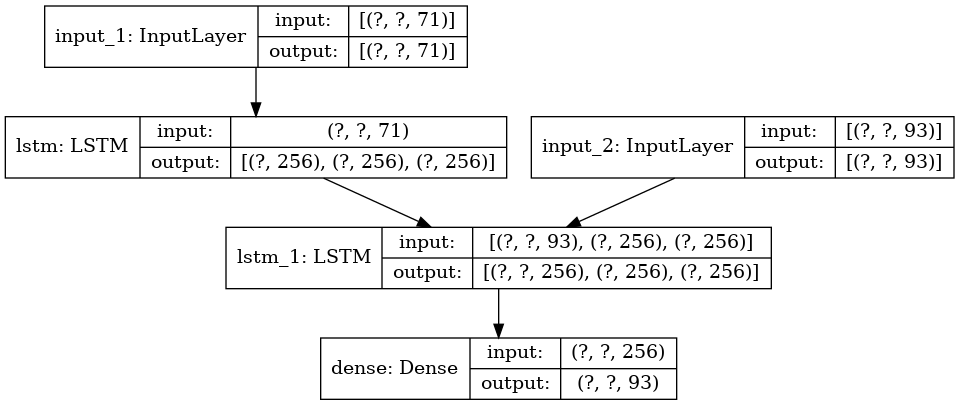

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]                   

### Model training

In [17]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 4s 28ms/step - loss: 1.1323 - accuracy: 0.7354 - val_loss: 1.0324 - val_accuracy: 0.7084
Epoch 2/100
125/125 [==============================] - 3s 23ms/step - loss: 0.8216 - accuracy: 0.7781 - val_loss: 0.8080 - val_accuracy: 0.7758
Epoch 3/100
125/125 [==============================] - 3s 21ms/step - loss: 0.6563 - accuracy: 0.8148 - val_loss: 0.7078 - val_accuracy: 0.7948
Epoch 4/100
125/125 [==============================] - 3s 21ms/step - loss: 0.5903 - accuracy: 0.8283 - val_loss: 0.6439 - val_accuracy: 0.8103
Epoch 5/100
125/125 [==============================] - 3s 21ms/step - loss: 0.5313 - accuracy: 0.8442 - val_loss: 0.5948 - val_accuracy: 0.8252
Epoch 6/100
125/125 [==============================] - 3s 21ms/step - loss: 0.4938 - accuracy: 0.8553 - val_loss: 0.5686 - val_accuracy: 0.8349
Epoch 7/100
125/125 [==============================] - 3s 21ms/step - loss: 0.4643 - accuracy: 0.8630 - val_loss: 0.5474 - val_accuracy:

### Restore the model and construct the encoder and decoder

In [18]:
# Define sampling models

model = keras.models.load_model("s2s")
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

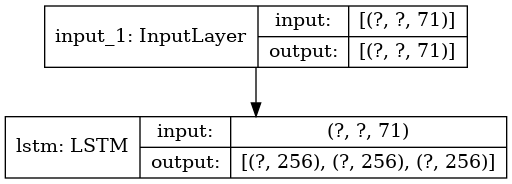

In [19]:
# summarize model
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)

In [20]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

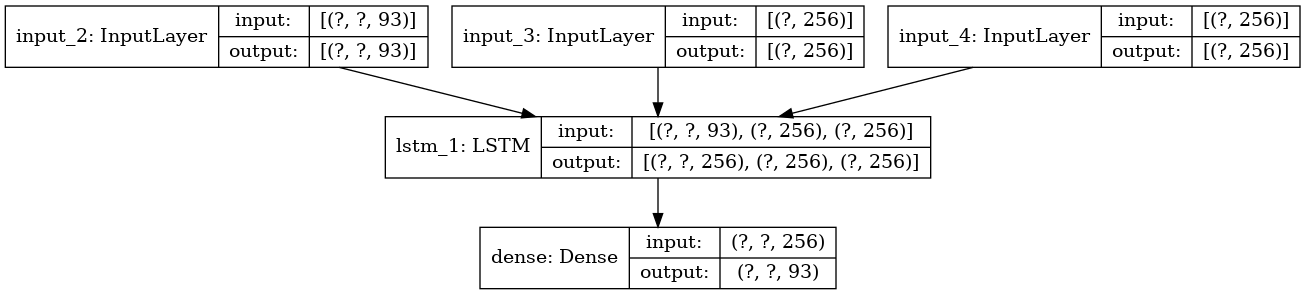

In [21]:
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)

In [22]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

### Use encoder_model and decoder_model to translate an input sentence from English to Frensh

In [23]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [24]:
for seq_index in range(40):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Bouge !

-
Input sentence: Go.
Decoded sentence: Bouge !

-
Input sentence: Go.
Decoded sentence: Bouge !

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Hi.
Decoded sentence: Salut.

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fu

### Sources:

https://keras.io/examples/nlp/lstm_seq2seq/

https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/